In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [3]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
[PCA] Explained variance of selected components : 63.02%
Power of components removed by DSS: 0.18
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.


In [4]:
data, indices, gfp, info_mne  = microstates_clean(raw_down_sampled, standardize_eeg=False, normalize=False, gfp_method='l2')
print(indices.shape, gfp.shape, data.shape)
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
#new_indices = np.argpartition(gfp_peakes, -1000)[-1000:]
#new_indices = np.sort(new_indices)
#print(new_indices)
#print(new_indices.shape)
gfp_data = data[:, indices]#[:, new_indices]
#print(neuro_gfp_data.shape)

(7686,) (48000,) (64, 48000)
(7686,)


5.006810106534817e-06


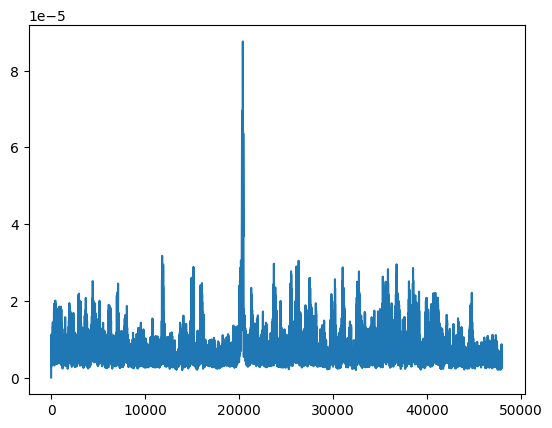

In [5]:
print(np.std(gfp_peakes))
plt.plot(gfp)
plt.show()

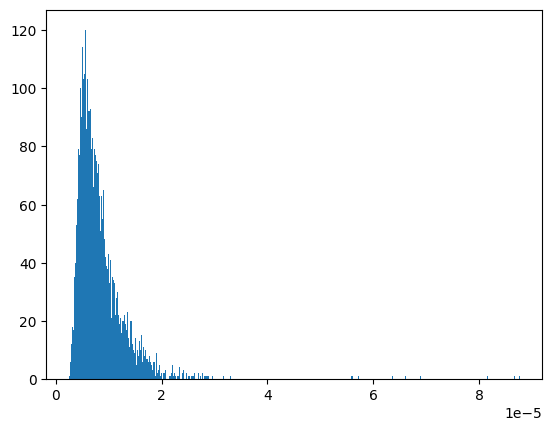

In [6]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [7]:
print(kurtosis(gfp_peakes))

57.71974762659018


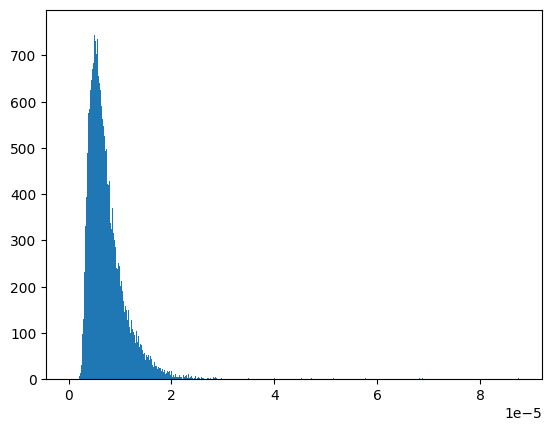

In [8]:
plt.hist(gfp, bins=1000)
plt.show()

In [9]:
print(kurtosis(gfp))
print(np.std(gfp))
print(np.mean(gfp))
print(np.mean(gfp) + np.std(gfp)*5)

69.02087019965055
4.743735687358121e-06
7.53373820331193e-06
3.125241664010254e-05


In [10]:
indices = np.delete(indices, np.arange(3183, 3258, 1))
gfp_peakes = np.delete(gfp_peakes, np.arange(3183, 3258, 1))


3.913849621569329e-06


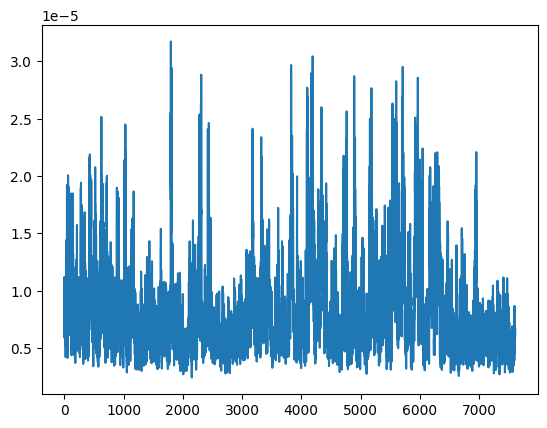

In [11]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes)
plt.show()

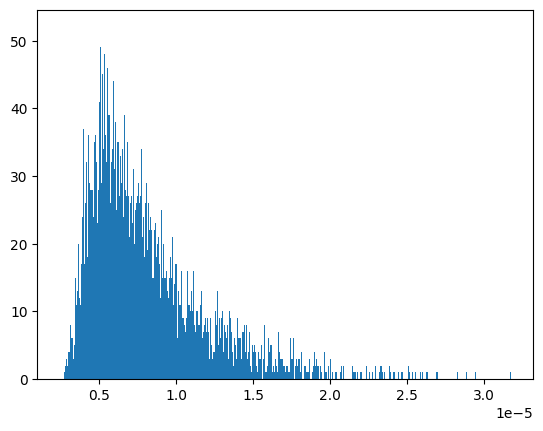

In [12]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [13]:
print(kurtosis(gfp_peakes))

3.34075651569138


In [14]:
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
gfp_data = data[:, indices]
print(gfp_data.shape)

(7611,)
(64, 7611)


In [15]:
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
drop = np.delete(all_inx, indices)


In [16]:
epochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [17]:
epochs.drop(drop)

Dropped 40389 epochs: 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 43, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 66, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 93, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 25

Number of events,7611
Events,1: 7611
Time range,0.000 – 0.000 s
Baseline,off


In [18]:
ica = mne.preprocessing.ICA(max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
    )

In [19]:
ica.fit(epochs)
#Do I feed enough data to ICA?

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Computing Extended Infomax ICA
Fitting ICA took 34.4s.


Method,infomax
Fit,500 iterations on epochs (7611 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


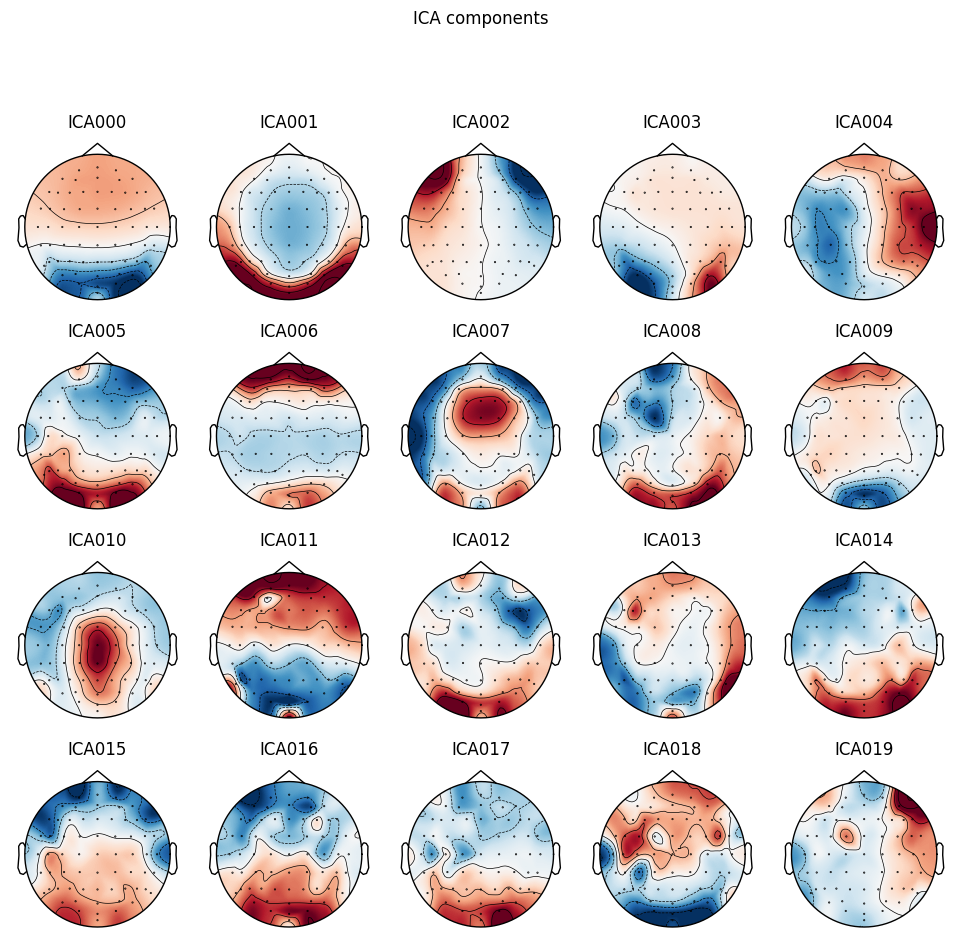

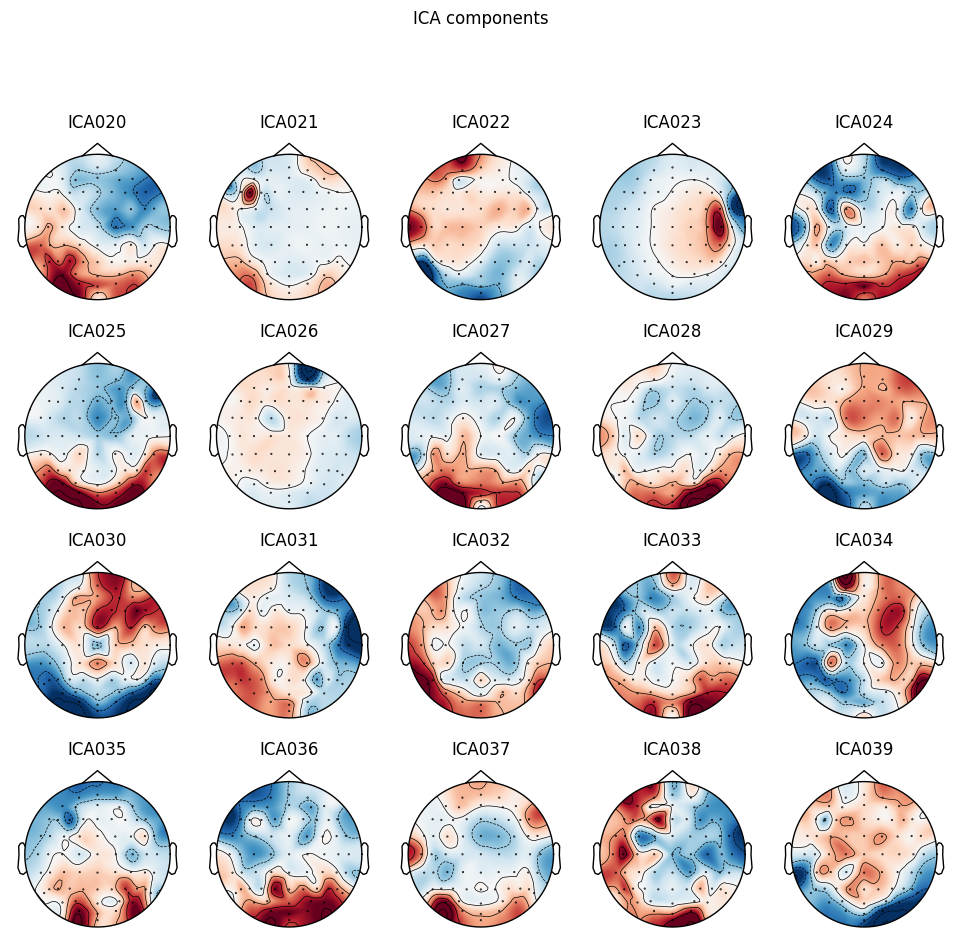

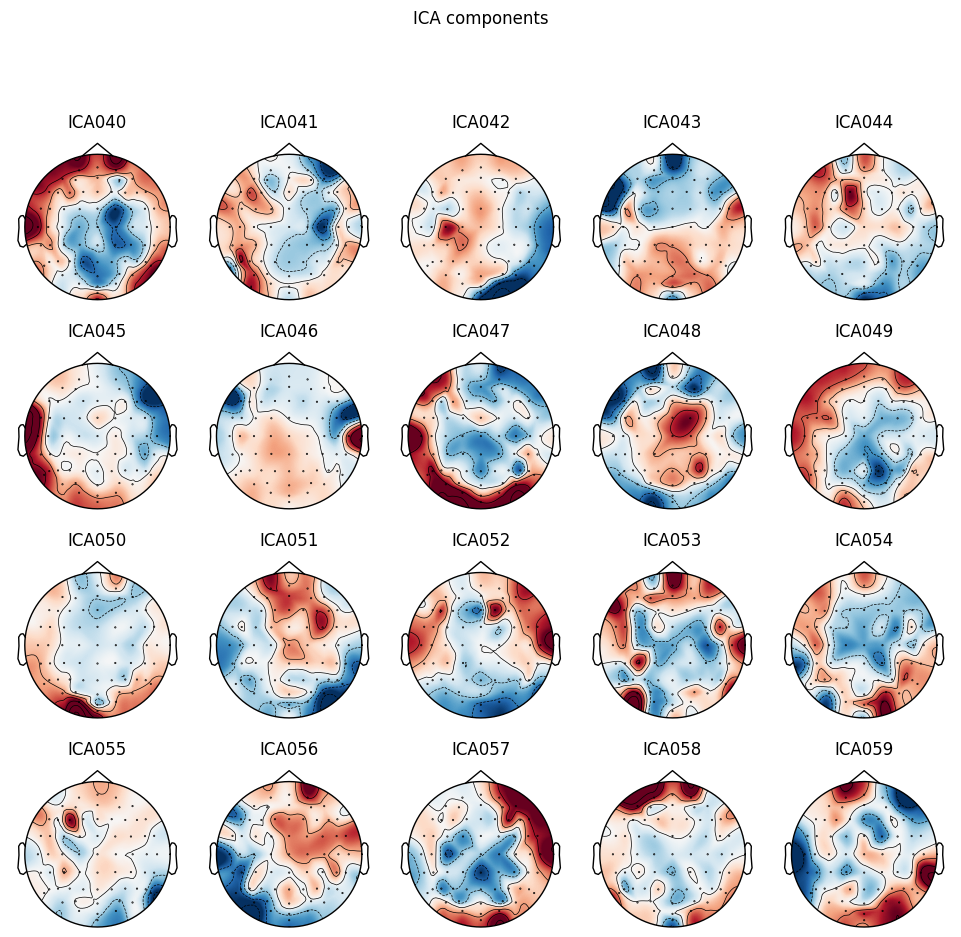

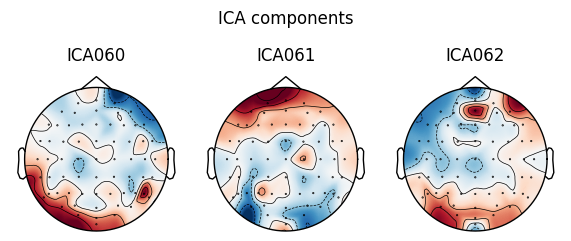

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 585x260.5 with 3 Axes>]

In [20]:
ica.plot_components()
#Something wierd with component 1 here for sure, hence the wish for bad segment excluder. 

In [21]:
ic_labels = label_components(raw_down_sampled, ica, method='iclabel')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [22]:
print(ic_labels)

{'y_pred_proba': array([0.9996984 , 0.94267917, 0.999848  , 0.99352723, 0.99505454,
       0.93504286, 0.49181944, 0.83597016, 0.93358666, 0.94291174,
       0.60243475, 0.86419606, 0.50335425, 0.98556423, 0.5184448 ,
       0.5402627 , 0.5028977 , 0.651192  , 0.6675241 , 0.7133013 ,
       0.74846584, 0.36765647, 0.49505794, 0.48573422, 0.78921413,
       0.76741976, 0.60638714, 0.89979094, 0.6251752 , 0.82983506,
       0.60784316, 0.4298476 , 0.63616794, 0.4646265 , 0.984956  ,
       0.69913226, 0.7528414 , 0.96315634, 0.898942  , 0.7387909 ,
       0.465556  , 0.78672403, 0.6918795 , 0.91386324, 0.8516393 ,
       0.40686578, 0.95522875, 0.9329861 , 0.9429022 , 0.8646054 ,
       0.7277734 , 0.9707836 , 0.77499855, 0.98292124, 0.8161831 ,
       0.9044086 , 0.94675213, 0.92468345, 0.5139378 , 0.96450955,
       0.9679408 , 0.98530376, 0.76117957], dtype=float32), 'labels': ['brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'eye blink', 'other', 'other', 'brain', 'brain', '

In [23]:
s = ica.get_sources(epochs)

In [24]:
s.get_data().shape

(7611, 63, 1)

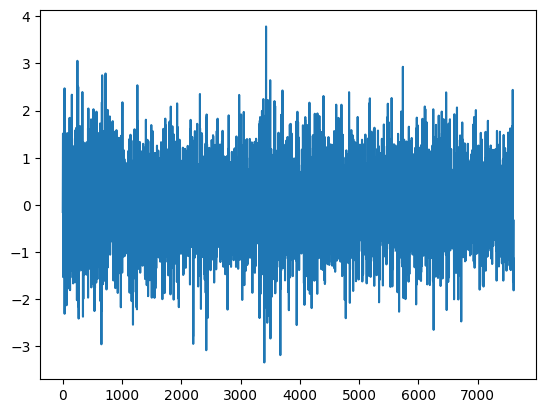

In [25]:
plt.plot(s.get_data()[:, 4, 0])
plt.show()

In [26]:
print(s.get_data()[1, 0, 0], s.get_data()[1, 1, 0], s.get_data()[1, 2, 0], s.get_data()[1, 3, 0], s.get_data()[1, 4, 0], s.get_data()[1, 5, 0], s.get_data()[1, 6, 0])

-0.5315226624215014 1.4641670983606958 0.009653588411856076 1.4334914117400452 0.2025968821189896 0.8966658256305995 0.18624452300933067


ICA charachteristics

In [27]:
from scipy.stats import median_abs_deviation

In [28]:
comps = ica.get_components()
comp_gfp_mad = median_abs_deviation(comps, 0)
comp_gfp_std = np.std(comps, 0)

In [29]:

print(comp_gfp_mad.shape)

(63,)


In [30]:
print(comp_gfp_mad)

[0.4299363  0.27991748 0.15186759 0.08695459 0.19691679 0.12566471
 0.08971117 0.10788548 0.1007656  0.06428368 0.07600913 0.11616447
 0.07377767 0.07474048 0.0810456  0.07371191 0.08801963 0.07832428
 0.07900715 0.05140861 0.07997814 0.03669994 0.05855223 0.04808678
 0.06038188 0.0510598  0.04325434 0.05489341 0.05920127 0.06448995
 0.05429122 0.05276723 0.03339319 0.05400178 0.06673142 0.04804324
 0.04332367 0.03737433 0.0307577  0.04760655 0.05287296 0.05209504
 0.03590582 0.05120923 0.02177689 0.02417455 0.03818568 0.04144405
 0.04251306 0.04833194 0.03990139 0.04138773 0.03686265 0.03262366
 0.04747087 0.02667461 0.03108209 0.03241305 0.03001516 0.03161044
 0.02354118 0.01387243 0.02652198]


In [31]:
print(comp_gfp_std)

[0.75684923 0.52864669 0.33334773 0.2962215  0.22771938 0.20094655
 0.19382227 0.16590957 0.16511864 0.1556329  0.13684281 0.13332176
 0.12440626 0.12117605 0.11959831 0.11712137 0.11354292 0.11227854
 0.11057723 0.11025515 0.10127265 0.09830468 0.09365078 0.08819162
 0.09195002 0.09059684 0.08964797 0.08962547 0.08945385 0.08558472
 0.08248273 0.08112575 0.04420821 0.07894858 0.07856586 0.07652929
 0.07424478 0.07343672 0.04045891 0.07228111 0.07012601 0.06891384
 0.06588042 0.06467774 0.03536944 0.06325562 0.0616271  0.06250802
 0.06164773 0.06097225 0.0606934  0.06067221 0.05814052 0.05695328
 0.0569124  0.05517466 0.05457734 0.05438631 0.05367818 0.05210832
 0.04825389 0.02630193 0.0444207 ]
